# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [7]:
!pip install pymongo

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [8]:
!pip install pymongo[srv]

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [9]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [10]:
!pip install tweepy

  Using cached tweepy-4.4.0-py2.py3-none-any.whl (65 kB)
  Using cached requests_oauthlib-1.3.0-py2.py3-none-any.whl (23 kB)
  Using cached oauthlib-3.1.1-py2.py3-none-any.whl (146 kB)
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [11]:
!pip install twitter

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [12]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [13]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [25]:
client = MongoClient(mongod_connect)
db = client.demo # use or create a database named demo
tweet_collection = db.final_project #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [ ]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [5]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

## Use the REST API to Collect Tweets

Authorize the REST API 

In [26]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [35]:
count = 100 #number of returned tweets, default and max is 100
geocode = "41.5810317,-93.7435034,200mi"  # defin the location, in Harrisonburg, VA
q = "COVID"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [36]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Wed Dec 01 21:28:47 +0000 2021'
'Wed Dec 01 21:28:27 +0000 2021'
'Wed Dec 01 21:28:14 +0000 2021'
'Wed Dec 01 21:28:12 +0000 2021'
'Wed Dec 01 21:27:45 +0000 2021'
'Wed Dec 01 21:25:58 +0000 2021'
'Wed Dec 01 21:25:46 +0000 2021'
'Wed Dec 01 21:24:24 +0000 2021'
'Wed Dec 01 21:24:24 +0000 2021'
'Wed Dec 01 21:24:04 +0000 2021'
'Wed Dec 01 21:24:02 +0000 2021'
'Wed Dec 01 21:23:27 +0000 2021'
'Wed Dec 01 21:21:03 +0000 2021'
'Wed Dec 01 21:20:08 +0000 2021'
'Wed Dec 01 21:19:44 +0000 2021'
'Wed Dec 01 21:19:11 +0000 2021'
'Wed Dec 01 21:19:04 +0000 2021'
'Wed Dec 01 21:18:56 +0000 2021'
'Wed Dec 01 21:16:41 +0000 2021'
'Wed Dec 01 21:15:09 +0000 2021'
'Wed Dec 01 21:14:31 +0000 2021'
'Wed Dec 01 21:14:04 +0000 2021'
'Wed Dec 01 21:12:53 +0000 2021'
'Wed Dec 01 21:12:45 +0000 2021'
'Wed Dec 01 21:12:29 +0000 2021'
'Wed Dec 01 21:12:15 +0000 2021'
'Wed Dec 01 21:12:13 +0000 2021'
'Wed Dec 01 21:11:04 +0000 2021'
'Wed Dec 01 21:11:01 +0000 2021'
'Wed Dec 01 21:09:42 +0000 2021'
'Wed Dec 0

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [38]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Mon Nov 29 16:44:40 +0000 2021'
'Mon Nov 29 16:44:13 +0000 2021'
'Mon Nov 29 16:44:00 +0000 2021'
'Mon Nov 29 16:43:26 +0000 2021'
'Mon Nov 29 16:43:05 +0000 2021'
'Mon Nov 29 16:40:58 +0000 2021'
'Mon Nov 29 16:36:21 +0000 2021'
'Mon Nov 29 16:35:24 +0000 2021'
'Mon Nov 29 16:30:55 +0000 2021'
'Mon Nov 29 16:30:36 +0000 2021'
'Mon Nov 29 16:30:00 +0000 2021'
'Mon Nov 29 16:29:52 +0000 2021'
'Mon Nov 29 16:29:30 +0000 2021'
'Mon Nov 29 16:29:24 +0000 2021'
'Mon Nov 29 16:28:29 +0000 2021'
'Mon Nov 29 16:28:12 +0000 2021'
'Mon Nov 29 16:26:56 +0000 2021'
'Mon Nov 29 16:25:57 +0000 2021'
'Mon Nov 29 16:25:37 +0000 2021'
'Mon Nov 29 16:25:20 +0000 2021'
'Mon Nov 29 16:24:30 +0000 2021'
'Mon Nov 29 16:24:29 +0000 2021'
'Mon Nov 29 16:24:27 +0000 2021'
'Mon Nov 29 16:22:48 +0000 2021'
'Mon Nov 29 16:21:50 +0000 2021'
'Mon Nov 29 16:20:01 +0000 2021'
'Mon Nov 29 16:19:55 +0000 2021'
'Mon Nov 29 16:19:54 +0000 2021'
'Mon Nov 29 16:19:42 +0000 2021'
'Mon Nov 29 16:19:32 +0000 2021'
'Mon Nov 2

'Mon Nov 29 09:40:00 +0000 2021'


KeyboardInterrupt: 

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [39]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

4073
2059


Create a text index and print the Tweets containing specific keywords. 

In [40]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [41]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "COVID"}}) # return tweets contain vote

Use pprint to display tweets

In [42]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: Iowa COVID-19 Tracker: Sara Anne Willette
text: Iowa COVID+ Update: 11/29/2021

Cumulative COVID+ Iowans: 522858
Cumulative COVID+ Tests: 567074
Cumulative COVID D… https://t.co/JyPgVdLQna
----
name: Iowa COVID-19 Tracker: Sara Anne Willette
text: Iowa COVID+ Update: 11/30/2021

Cumulative COVID+ Iowans: 525458
Cumulative COVID+ Tests: 567074
Cumulative COVID D… https://t.co/wtLlJu9cn8
----
name: Iowa COVID-19 Tracker: Sara Anne Willette
text: Iowa COVID+ Update: 12/1/2021

Cumulative COVID+ Iowans: 529383
Cumulative COVID+ Tests: 570581
Cumulative COVID De… https://t.co/T9txihcQfR
----
name: Nick Stalcup ✍️
text: I’m tired of the Greek alphabet names for these COVID variants. Lmk when we get a Lil Covid or a Yung Covid.
----
name: Michael Foster
text: Covid is covid what do we have to do to get rid of it Joe.
----
name: I See Stupid People
text: PSA. Vaccines don't prevent Covid-19.  Vaccinated people can catch and spread Covid-19. Covid-19 is always going to… https://t.co/

In [24]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "COVID"}}) # return tweets contain vote

Use pandas to display tweets

In [13]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,...,lang,timestamp_ms,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,extended_tweet,possibly_sensitive,metadata,display_text_range
0,5f9970e6ea281243abe9e85f,Wed Oct 28 13:23:45 +0000 2020,1321442530572066817,1321442530572066817,RT @Mia4MD: Early Voting is happening NOW in M...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,en,1603891425160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5f9970eaea281243abe9e8c9,Wed Oct 28 13:23:49 +0000 2020,1321442549718945792,1321442549718945792,RT @Amy_Siskind: TEXAS‼️ - an astounding 7.8 m...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,en,1603891429725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5f9970efea281243abe9e939,Wed Oct 28 13:23:54 +0000 2020,1321442568459198467,1321442568459198467,KEEP Pres: TRUMP\nCHANGE Senate: GADE\nHOPE Co...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",True,NaN,None,NaN,...,en,1603891434193,1.321379e+18,1321378894327484416,{'created_at': 'Wed Oct 28 09:10:53 +0000 2020...,"{'url': 'https://t.co/g07jyouj2s', 'expanded':...",{'full_text': 'KEEP Pres: TRUMP CHANGE Senate:...,NaN,NaN,NaN
3,5f997133ea281243abe9ea5a,Wed Oct 28 13:25:02 +0000 2020,1321442853244018690,1321442853244018690,#VOTE,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,None,NaN,...,und,1603891502091,1.321441e+18,1321440905098874882,{'created_at': 'Wed Oct 28 13:17:17 +0000 2020...,"{'url': 'https://t.co/SiYtZzvyXq', 'expanded':...",NaN,NaN,NaN,NaN
4,5f9970e6ea281243abe9e868,Wed Oct 28 13:23:45 +0000 2020,1321442531532435457,1321442531532435457,#Vote,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,und,1603891425389,1.321180e+18,1321179867052986368,{'created_at': 'Tue Oct 27 20:00:01 +0000 2020...,"{'url': 'https://t.co/VhdpN9qfYf', 'expanded':...",NaN,NaN,NaN,NaN
5,5f9970f5ea281243abe9e9b4,Wed Oct 28 13:24:00 +0000 2020,1321442594174455809,1321442594174455809,RT @grantstern: Why is ⁦@MayorGimenez⁩ against...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,...,en,1603891440324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5f9970eaea281243abe9e8c6,Wed Oct 28 13:23:49 +0000 2020,1321442549379334144,1321442549379334144,RT @raquelmiranda89: Shelby County: you have t...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,en,1603891429644,1.316336e+18,1316335746702340097,{'created_at': 'Wed Oct 14 11:11:13 +0000 2020...,"{'url': 'https://t.co/AbysBKfi2s', 'expanded':...",NaN,NaN,NaN,NaN
7,5f9970f9ea281243abe9ea15,Wed Oct 28 13:24:04 +0000 2020,1321442610347737088,1321442610347737088,I'm not voting until a celebrity tweets a pict...,"<a href=""http://twitter.com/download/android"" ...",True,NaN,None,NaN,...,en,1603891444180,NaN,NaN,NaN,NaN,{'full_text': 'I'm not voting until a celebrit...,NaN,NaN,NaN
8,5f997133ea281243abe9ea5b,Wed Oct 28 13:25:02 +0000 2020,1321442853617164289,1321442853617164289,RT @kkjjPNW: You do not have to vote by mail i...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,en,1603891502180,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
9,5f9970faea281243abe9ea39,Wed Oct 28 13:24:05 +0000 2020,1321442617138286594,1321442617138286594,RT @Carnage4Life: It’s easier for a white pers...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,en,1603891445799,1.320028e+18,1320027534789140480,{'created_at': 'Sat Oct 24 15:41:03 +0000 2020...,"{'url': 'https://t.co/8u0q776vmb', 'expanded':...",NaN,NaN,NaN,NaN


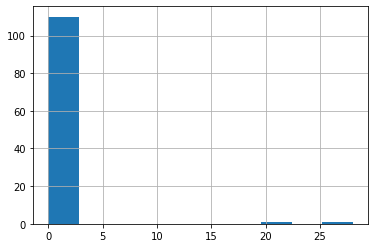

In [14]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count